In [1]:
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import numpy as np
from scipy import spatial
from astropy.table import Table
from astropy.cosmology import LambdaCDM as Cos
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
from IPython import display 
from scipy import stats
from scipy.interpolate import interp1d, interp2d
from scipy.stats import norm
import fitsio

import time

import pickle
import dask
pd.options.mode.chained_assignment = None

In [2]:
points_ref = np.array([(1, 1), (3, 3), (4, 4), (5, 4), (6, 6)])
tree = spatial.cKDTree(points_ref)

In [3]:
idx = tree.query_ball_point((4, 4), 2)
points_ref[idx]

array([[3, 3],
       [4, 4],
       [5, 4]])

In [4]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers = 10)
client = Client(cluster)
client

/global/homes/m/mjyb16/.conda/envs/nersc_clusters/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39863 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:45515 Dashboard: http://127.0.0.1:39863/status,Cluster Workers: 10 Cores: 260 Memory: 503.14 GiB


In [5]:
#client.close()

In [5]:
# load table of centers
table_of_centers = pd.read_csv("/pscratch/sd/m/mjyb16/dr9_files.csv")
table_of_centers_south_uncorrected = table_of_centers[0:455].copy()
table_of_centers_north = table_of_centers[455:].copy()
#table_of_centers_south = table_of_centers_south[200:].copy()
table_of_centers_south_uncorrected.reset_index(inplace = True, drop = True)
clusters = []
#testing_centers = pd.read_csv("testing_sweeps_dr9.csv")
#testing_centers = table_of_centers_south[50:72]
#testing_centers = testing_centers[1:]

In [6]:
np.seterr(divide = 'ignore', invalid = "ignore")
#np.seterr(divide = 'warn', invalid = 'warn')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [7]:
#Finding neighboring sweeps
nbrs = NearestNeighbors(n_neighbors=9, algorithm='ball_tree').fit(table_of_centers_north[["mean_RA", "mean_DEC"]].values.astype(float))

In [8]:
@dask.delayed
def data_import(maxx, maxy, minx, miny, row2):
    buffer = 0.285
    fits_data = fitsio.FITS(row2.patch)
    sweep = fits_data[1].read(columns=['RELEASE','BRICKID','BRICKNAME', 'OBJID', 'TYPE', 'RA', 'DEC', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'MASKBITS', 'GAIA_PHOT_G_MEAN_MAG', 'GAIA_ASTROMETRIC_EXCESS_NOISE'])
    data = Table.read(row2.photoz, format = "fits")
    pz = data.to_pandas()
    #with fits.open(row2.photoz) as data:
    #    pz = pd.DataFrame(data[1].data)
    mass = np.load(row2.masses)
    
    pz['mass'] = mass
    pz['RELEASE']=sweep['RELEASE']
    pz['BRICKID']=sweep['BRICKID']
    pz['BRICKNAME']=sweep['BRICKNAME']
    pz['OBJID']=sweep['OBJID']
    pz['TYPE']=sweep['TYPE']
    pz['RA']=sweep['RA']
    pz['DEC']=sweep['DEC']
    pz['FLUX_G']=sweep['FLUX_G']
    pz['FLUX_R']=sweep['FLUX_R']
    pz['FLUX_Z']=sweep['FLUX_Z']
    pz['FLUX_W1']=sweep['FLUX_W1']
    pz['MASKBITS']=sweep['MASKBITS']
    pz['gaia_phot_g_mean_mag']=sweep['GAIA_PHOT_G_MEAN_MAG']
    pz['gaia_astrometric_excess_noise']=sweep['GAIA_ASTROMETRIC_EXCESS_NOISE']
    pz = pz[np.logical_and.reduce((pz.RA < maxx + buffer/np.cos(pz.DEC*(np.pi/180)), pz.DEC < maxy + buffer, pz.RA > minx - buffer/np.cos(pz.DEC*(np.pi/180)), pz.DEC > miny - buffer))]
    return pz

In [12]:
def cluster_finder(massive_sample_original, iterrator, indexable, gauss_array, maxRA, maxDEC, minRA, minDEC, oversample, radius = 1, small_radius = 0.5, mini_radius = 0.1):
    #Mass fitting parameters and equations
    a = 1.3620186928378857  
    b = 9.968545069745126
    j= 1.04935943 
    k = 0.39573094 
    l = 0.28347756
    def mass_limit(z):
        return np.minimum((a*z + b), 11.2)

    def mass_coefficient(z):
        return np.exp(j*z**2 + k*z + l)
    
    #Radii
    radius = 1
    small_radius = 0.5
    mini_radius = 0.1
    #Cosmological Parameters: radius and cylinder length
    #Setting cylinder size
    cos = Cos(H0 = 70, Om0 = .286, Ode0 = .714)
    z_array = np.linspace(1e-2, 2, 500)
    sparse_radius = (1+z_array)/(cos.comoving_distance(z_array))
    radius_threshold = interp1d(z_array, sparse_radius, kind = "linear", fill_value = "extrapolate")
    z_source = Table.read("threshold_training_north_2.fits", format = "fits")
    #z_source = Table.read("threshold_training_south.fits", format = "fits")
    z_data_array = z_source.to_pandas()
    z_threshold = interp1d(z_data_array.z, z_data_array.sigma_z_threshold, kind = "linear", fill_value = "extrapolate")

    #Setting neighbor thresholds
    t_source = Table.read("neighbor_training_north_2.fits", format = "fits")
    #t_source = Table.read("neighbor_training_south.fits", format = "fits")
    t_data_array = t_source.to_pandas()
    thresh1 = interp1d(t_data_array.z, t_data_array.neighbor_threshold1, kind = "linear", fill_value = "extrapolate")
    thresh2 = interp1d(t_data_array.z, t_data_array.neighbor_threshold2, kind = "linear", fill_value = "extrapolate")
    
    #Reweightings
    bins_z = np.linspace(0.1, 1.0, 21)
    
    smoothed_reweightings = np.load("reweighting_north_extrapolated.npy")
    edges = np.linspace(-.6, .6, 201)
    interpolated_reweighting_extrapolate = interp2d(x = 0.5*(edges[1:]+edges[:-1]), y = 0.5*(bins_z[:-1] + bins_z[1:]), z = smoothed_reweightings)
    
    smoothed_reweightings = np.load("reweighting_north_nan_fill.npy")
    edges = np.linspace(-1, 1, 201)
    interpolated_reweighting_nan = interp2d(x = 0.5*(edges[1:]+edges[:-1]), y = 0.5*(bins_z[:-1] + bins_z[1:]), z = smoothed_reweightings)
    plt.figure(figsize = (20, 2))
    x_array = np.linspace(-1, 1, 2000)
    y_array = np.linspace(0, 1, 400)
    z_vals = interpolated_reweighting_nan(x_array, y_array)
    plt.imshow(z_vals)
    plt.colorbar()
    plt.show()
    
    
    #Mass fitting parameters and equations
    a = 1.3620186928378857  
    b = 9.968545069745126
    j= 1.04935943 
    k = 0.39573094 
    l = 0.28347756
    def mass_limit(z):
        return np.minimum((a*z + b), 11.2)

    def mass_coefficient(z):
        return np.exp(j*z**2 + k*z + l)
    
    #Tree Algorithm
    massive_sample = massive_sample_original.copy()
    massive_sample_2 = massive_sample_original.copy()
    tree = spatial.cKDTree(indexable[:, 1:3].astype(float), copy_data = True)
    for i, row in iterrator.iterrows():
        neighbors = tree.query_ball_point([row.x, row.y], radius_threshold(row.Z_PHOT_MEDIAN))
        if len(neighbors) > 0:
            local_data = indexable[neighbors]
            gauss = gauss_array[neighbors]
            
            z_c = z_threshold(row.Z_PHOT_MEDIAN)
            #cylinder = np.abs(np.vstack(gauss) - row.Z_PHOT_MEDIAN) #try reshape, try ravel, try flatten to make it 1-D. Try adding interp1D
            cylinder = np.abs(np.reshape(np.concatenate(gauss.flatten()), (len(gauss), oversample)) - row.Z_PHOT_MEDIAN)
            weight_array = cylinder < 2*z_c
            weights = weight_array.sum(axis = 1)/oversample
            deltas = local_data[:, 0] - row.Z_PHOT_MEDIAN
            reweights = interpolated_reweighting_extrapolate(deltas, row.Z_PHOT_MEDIAN)
            reweights_nan = interpolated_reweighting_nan(deltas, row.Z_PHOT_MEDIAN)
            
            approx_cluster_0_0 = np.append(local_data, np.reshape(weights, newshape = (len(weights), 1)), axis = 1)
            approx_cluster_0 = np.append(approx_cluster_0_0, np.reshape(weights*reweights, newshape = (len(weights), 1)), axis = 1)
            approx_cluster = np.append(approx_cluster_0, np.reshape(weights*np.round(reweights_nan), newshape = (len(weights), 1)), axis = 1)
            
            cluster = approx_cluster[np.logical_and(approx_cluster[:, -1] > 0, approx_cluster[:, -2] > 0)]
            if sum(approx_cluster[:, -1] > 0) < sum(approx_cluster[:, -3] > 0):
                print(row.Z_PHOT_MEDIAN)
                print(deltas)
                print(reweights_nan)
                print(weights)
                print(approx_cluster[:, -3])
                print(approx_cluster[:, -1])
            #cluster = approx_cluster[approx_cluster[:, -3] > 0]
            if len(cluster)>0:
                r_smaller = radius_threshold(row.Z_PHOT_MEDIAN)
                small_cluster = cluster[np.sqrt(np.array((cluster[:, 1] - row.x)**2 + (cluster[:, 2] - row.y)**2, dtype = float)) < 0.5*r_smaller]
                mini_cluster = cluster[np.sqrt(np.array((cluster[:, 1] - row.x)**2 + (cluster[:, 2] - row.y)**2, dtype = float)) < 0.1*r_smaller]

                massive_sample.at[i, "z_average_no_wt"] = np.mean(cluster[:, 0], dtype=np.float64)
                massive_sample.at[i, "z_average_prob"] = np.average(cluster[:, 0], weights = cluster[:, -3])
                massive_sample.at[i, "z_average_mass_prob"] = np.average(cluster[:, 0], weights = cluster[:, -3]*cluster[:, 3])
                
                massive_sample.at[i, "z_average_prob_reweighted"] = np.average(cluster[:, 0], weights = cluster[:, -2])
                massive_sample.at[i, "z_average_mass_prob_reweighted"] = np.average(cluster[:, 0], weights = cluster[:, -2]*cluster[:, 3])
                
                massive_sample.at[i, "z_average_prob_reweighted_nan"] = np.average(cluster[:, 0], weights = cluster[:, -1])
                massive_sample.at[i, "z_average_mass_prob_reweighted_nan"] = np.average(cluster[:, 0], weights = cluster[:, -1]*cluster[:, 3])
                
                std_no_weight = np.std(cluster[:, 0], dtype=np.float64)
                std_prob = np.sqrt(np.cov(cluster[:, 0], aweights = cluster[:, -3]))
                std_prob_mass = np.sqrt(np.cov(cluster[:, 0], aweights = cluster[:, -3]*cluster[:, 3]))
                massive_sample.at[i, "z_std_no_wt"] = std_no_weight
                massive_sample.at[i, "z_std_prob"] = std_prob
                massive_sample.at[i, "z_std_mass_prob"] = std_prob_mass
                
                n_no_weight = len(cluster[:, 0])
                n_prob = np.sum(cluster[:, -3])**2/np.sum(cluster[:, -3]**2)
                n_mass_prob = np.sum(cluster[:, -3]*cluster[:, 3])**2/np.sum((cluster[:, -3]*cluster[:, 3])**2)
                massive_sample.at[i, "z_stde_no_wt"] = std_no_weight/np.sqrt(n_no_weight)
                massive_sample.at[i, "z_stde_prob"] = std_prob/np.sqrt(n_prob)
                massive_sample.at[i, "z_stde_mass_prob"] = std_prob_mass/np.sqrt(n_mass_prob)

                massive_sample.at[i, "neighbors"] = np.sum(cluster[:, -3])
                massive_sample.at[i, "local_neighbors"] = np.sum(small_cluster[:, -3])
                massive_sample.at[i, "ultra_local_neighbors"] = np.sum(mini_cluster[:, -3])
                
                massive_sample.at[i, "neighbors_reweighted"] = np.sum(cluster[:, -2])
                massive_sample.at[i, "local_neighbors_reweighted"] = np.sum(small_cluster[:, -2])
                massive_sample.at[i, "ultra_local_neighbors_reweighted"] = np.sum(mini_cluster[:, -2])
                
                massive_sample.at[i, "neighbors_reweighted_nan"] = np.sum(cluster[:, -1])
                massive_sample.at[i, "local_neighbors_reweighted_nan"] = np.sum(small_cluster[:, -1])
                massive_sample.at[i, "ultra_local_neighbors_reweighted_nan"] = np.sum(mini_cluster[:, -1])

                mass_co = mass_coefficient(row.Z_PHOT_MEDIAN)
                massive_sample.at[i, "correction_factor"] = mass_co
                c_mask = cluster[:, 3]>mass_limit(row.Z_PHOT_MEDIAN)
                cluster_limited = cluster[c_mask.astype("bool"), :]
                c_mask_small = small_cluster[:, 3]>mass_limit(row.Z_PHOT_MEDIAN)
                small_cluster_limited = small_cluster[c_mask_small.astype("bool"), :]
                c_mask_mini = mini_cluster[:, 3]>mass_limit(row.Z_PHOT_MEDIAN)
                mini_cluster_limited = mini_cluster[c_mask_mini.astype("bool"), :]
                massive_sample.at[i, "neighbor_mass"] = np.log10(np.sum(np.append(((10**cluster_limited[:, 3]))*cluster_limited[:, -3], [10**row.mass]))*mass_co)
                massive_sample.at[i, "local_neighbor_mass"] = np.log10(np.sum(np.append((10**small_cluster[:, 3])*small_cluster[:, -3], [10**row.mass])))
                massive_sample.at[i, "ultra_local_neighbor_mass"] = np.log10(np.sum(np.append((10**mini_cluster[:, 3])*mini_cluster[:, -3], [10**row.mass])))
                
                massive_sample.at[i, "neighbor_mass_reweighted"] = np.log10(np.sum(np.append(((10**cluster_limited[:, 3]))*cluster_limited[:, -3], [10**row.mass]))*mass_co)
                massive_sample.at[i, "local_neighbor_mass_reweighted"] = np.log10(np.sum(np.append((10**small_cluster[:, 3])*small_cluster[:, -3], [10**row.mass])))
                massive_sample.at[i, "ultra_local_neighbor_mass_reweighted"] = np.log10(np.sum(np.append((10**mini_cluster[:, 3])*mini_cluster[:, -3], [10**row.mass])))
                
                massive_sample.at[i, "neighbor_mass_reweighted_nan"] = np.log10(np.sum(np.append(((10**cluster_limited[:, 3]))*cluster_limited[:, -3], [10**row.mass]))*mass_co)
                massive_sample.at[i, "local_neighbor_mass_reweighted_nan"] = np.log10(np.sum(np.append((10**small_cluster[:, 3])*small_cluster[:, -3], [10**row.mass])))
                massive_sample.at[i, "ultra_local_neighbor_mass_reweighted_nan"] = np.log10(np.sum(np.append((10**mini_cluster[:, 3])*mini_cluster[:, -3], [10**row.mass])))
                
                massive_sample.at[i, "corr_local_neighbor_mass"] = np.log10(np.sum(np.append((10**small_cluster_limited[:, 3])*small_cluster_limited[:, -1], [10**row.mass]))*mass_co)
                massive_sample.at[i, "corr_ultra_local_neighbor_mass"] = np.log10(np.sum(np.append((10**mini_cluster_limited[:, 3])*mini_cluster_limited[:, -1], [10**row.mass]))*mass_co)

                clusterid = np.ones((1, len(local_data)))*row.gid
                clusterz = np.ones((1, len(local_data)))*row.Z_PHOT_MEDIAN
                membership = np.concatenate((local_data[:, 4].reshape((1, len(local_data))), clusterid, local_data[:, 3].reshape((1, len(local_data))), local_data[:, 0].reshape((1, len(local_data))), clusterz, local_data[:, 5].reshape((1, len(local_data)))), axis = 0).T
                massive_sample.at[i, "neighbor_gids"] = membership
            else:
                clusterid = np.ones((1, len(local_data)))*row.gid
                clusterz = np.ones((1, len(local_data)))*row.Z_PHOT_MEDIAN
                membership = np.concatenate((local_data[:, 4].reshape((1, len(local_data))), clusterid, local_data[:, 3].reshape((1, len(local_data))), local_data[:, 0].reshape((1, len(local_data))), clusterz, local_data[:, 5].reshape((1, len(local_data)))), axis = 0).T
                massive_sample.at[i, "neighbor_gids"] = membership
            
    
    #Thresholding
    clusters = massive_sample[np.logical_and(massive_sample.neighbors >= thresh1(massive_sample.Z_PHOT_MEDIAN), massive_sample.local_neighbors >= thresh2(massive_sample.Z_PHOT_MEDIAN))].copy()
    clusters.sort_values("local_neighbor_mass", inplace = True, ascending = False)
    clusters.reset_index(inplace= True, drop = True)
    
    #Aggregation
    tree = spatial.cKDTree(clusters[["x", "y"]], copy_data = True)
    clusters["ncluster"] = np.zeros(len(clusters))
    clusternum = 1
    iterrator2 = clusters.copy()
    for i, row in iterrator2.iterrows():
        if clusters.iloc[i].ncluster == 0:
            clusters.at[i, "ncluster"] = clusternum
            neighbors = tree.query_ball_point([row.x, row.y], 1.5*radius_threshold(row.Z_PHOT_MEDIAN))
            for index in neighbors:
                if np.logical_and(clusters.at[index, "ncluster"] == 0, np.abs(clusters.at[index, "Z_PHOT_MEDIAN"] - row.Z_PHOT_MEDIAN) < 2*z_threshold(row.Z_PHOT_MEDIAN)):
                    clusters.at[index, "ncluster"] = clusternum
                    #clusters.at[i, "neighbor_gids"] = np.concatenate((clusters.at[i, "neighbor_gids"], clusters.at[index, "neighbor_gids"]), axis = 0) 
            clusternum += 1
    
    #Results
    cluster_center = clusters.sort_values(by = ['ncluster','ultra_local_neighbor_mass'], ascending = [True, False]).groupby('ncluster').head(1).copy()
    cluster_center_selected = cluster_center[np.logical_and.reduce((cluster_center.RA < maxRA, cluster_center.RA > minRA, cluster_center.DEC < maxDEC, cluster_center.DEC > minDEC))].copy()
    
    
    #Cleaning things up
    cluster_center_selected["BRICKNAME"] = cluster_center_selected["BRICKNAME"].astype('|S80')
    clusters_final = cluster_center_selected[["Z_PHOT_MEDIAN", "z_average_no_wt", "z_average_prob", "z_average_mass_prob", \
                                              "z_average_prob_reweighted", "z_average_mass_prob_reweighted", \
                                              "z_average_prob_reweighted_nan", "z_average_mass_prob_reweighted_nan", \
                                              "neighbors", "local_neighbors", "ultra_local_neighbors", \
                                              "neighbors_reweighted", "local_neighbors_reweighted", "ultra_local_neighbors_reweighted", \
                                              "neighbors_reweighted_nan", "local_neighbors_reweighted_nan", "ultra_local_neighbors_reweighted_nan", \
                                              "neighbor_mass", "local_neighbor_mass", "ultra_local_neighbor_mass", \
                                              "neighbor_mass_reweighted", "local_neighbor_mass_reweighted", "ultra_local_neighbor_mass_reweighted",\
                                              "neighbor_mass_reweighted_nan", "local_neighbor_mass_reweighted_nan", "ultra_local_neighbor_mass_reweighted_nan"]].copy()
    clusters_final.columns = ["z_median_central", "z_average_no_wt", "z_average_prob", "z_average_mass_prob", \
                                              "z_average_prob_reweighted", "z_average_mass_prob_reweighted", \
                                              "z_average_prob_reweighted_nan", "z_average_mass_prob_reweighted_nan", \
                                              "neighbors", "local_neighbors", "ultra_local_neighbors", \
                                              "neighbors_reweighted", "local_neighbors_reweighted", "ultra_local_neighbors_reweighted", \
                                              "neighbors_reweighted_nan", "local_neighbors_reweighted_nan", "ultra_local_neighbors_reweighted_nan", \
                                              "neighbor_mass", "local_neighbor_mass", "ultra_local_neighbor_mass", \
                                              "neighbor_mass_reweighted", "local_neighbor_mass_reweighted", "ultra_local_neighbor_mass_reweighted", \
                                              "neighbor_mass_reweighted_nan", "local_neighbor_mass_reweighted_nan", "ultra_local_neighbor_mass_reweighted_nan"]
    return clusters_final
    #return ["test"], ["test"]

In [22]:
values = np.array([-4.33554232e-01,  1.56219661e-01, -5.36147416e-01,  1.98523760e-01,
          7.39947557e-02, -3.67197394e-02, -2.76241601e-01, -1.94984317e-01,
          1.53786123e-01, -5.03956079e-01, -3.55279833e-01, -6.81901574e-02,
          1.27557337e-01, -4.69263047e-01, -4.52413842e-01,  8.16196203e-02,
         -5.36717892e-01, -1.01774931e-02, -4.99915555e-01, -3.03578138e-01,
          6.75907135e-02, -2.11697310e-01,  2.37745643e-02, -5.31554878e-01,
          7.51403570e-02,  0.00000000e+00, -3.98596972e-01, -5.82429498e-01,
         -1.04842722e-01, -9.49725509e-02, -4.51369181e-01, -1.22879565e-01,
         -2.80975223e-01,  7.39022493e-02, -4.63309661e-01, -1.83816195e-01,
         -2.44738489e-01, -3.04342240e-01, -3.70789170e-02, -4.37087849e-01,
         -4.90373373e-02, -4.32576939e-01, -1.11937523e-04, -4.86727729e-01,
         -2.44560212e-01, -1.18353367e-01, -2.24452734e-01])

print(interpolated_reweighting_nan(values, 0.66255122423172))

idx = np.argsort(np.argsort(values))
values_sorted = np.sort(values)

[0.26415707 0.26848115 0.27103474 0.26798872 0.12399083 0.12322109
 0.15001199 0.21607599 0.24438589 0.28124717 0.28230528 0.28234733
 0.28300045 0.28458516 0.3528933  0.41103096 0.35986325 0.35793017
 0.32957242 0.33056089 0.32815541 0.32841032 0.36845433 0.3956477
 0.4259336  0.44063884 0.65284633 0.66515863 0.68890312 0.6944321
 0.73144059 0.79546246 0.84634292 0.84791258 0.95475882 0.97870779
 0.97890047 0.99578035 1.         1.         1.         1.
 1.         1.         1.         1.         1.        ]


In [18]:
values[-1]

-0.224452734

In [24]:
print(interpolated_reweighting_nan(values[-1], 0.66255122423172))
print(interpolated_reweighting_nan(values, 0.66255122423172)[-1])
print(interpolated_reweighting_nan(values_sorted, 0.66255122423172)[idx][-1])

[0.36845433]
1.0
0.368454333058328


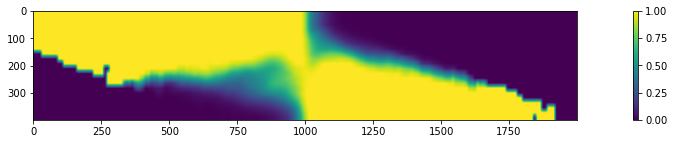

In [15]:
bins_z = np.linspace(0.1, 1.0, 21)
smoothed_reweightings = np.load("reweighting_north_nan_fill.npy")
edges = np.linspace(-1, 1, 201)
interpolated_reweighting_nan = interp2d(x = 0.5*(edges[1:]+edges[:-1]), y = 0.5*(bins_z[:-1] + bins_z[1:]), z = smoothed_reweightings)
plt.figure(figsize = (20, 2))
x_array = np.linspace(-1, 1, 2000)
y_array = np.linspace(0, 1, 400)
z_vals = interpolated_reweighting_nan(x_array, y_array)
plt.imshow(z_vals)
plt.colorbar()
plt.show()

In [13]:
delayed_results = []
pbar = display.ProgressBar(62)
pbar.display()

#Remember to change testing_centers to table_of_centers
for index, row in table_of_centers_north[1:61].iterrows():
    fits_data = fitsio.FITS(row.patch)
    sweep = fits_data[1].read(columns=['RA', 'DEC'])
    print(len(sweep))
    maxx = max(sweep['RA'])
    maxy = max(sweep['DEC'])
    minx = min(sweep['RA'])
    miny = min(sweep['DEC'])

    maxRA = max(sweep['RA'])
    maxDEC = max(sweep['DEC'])
    minRA = min(sweep['RA'])
    minDEC = min(sweep['DEC'])

    list_of_imports = []
    #Neighbors:
    distances, indices = nbrs.kneighbors([row[["mean_RA", "mean_DEC"]].values.astype(float)])

    patches = table_of_centers_north.iloc[indices[0]]
    #patches = table_of_centers_south.iloc[indices[0]]
    for index2, row2 in patches.iterrows():
        delayed_import = data_import(maxx, maxy, minx, miny, row2)
        list_of_imports.append(delayed_import)

    imports = dask.compute(*list_of_imports)
    print("done import")
    ra_dec = pd.concat(imports)
    #ra_dec = pd.concat(list_of_imports)
    #Initial sample cuts
    zmag=np.array(22.5-2.5*np.log10(ra_dec.FLUX_Z))
    zmag[np.where(~np.isfinite(zmag))]=99.
    #whgood=np.where(np.logical_and(zmag < 21,ra_dec.mass > 0 ))
    isgood=np.logical_and(zmag < 21,ra_dec.mass > 0)
    ra_dec = ra_dec[isgood]

    #Further sample cuts
    ra_dec = ra_dec[np.logical_or(ra_dec.MASKBITS == 0, ra_dec.MASKBITS == 4096)]
    ra_dec = ra_dec[np.logical_or(np.logical_or(ra_dec.gaia_phot_g_mean_mag > 19, ra_dec.gaia_astrometric_excess_noise > 10**.5), ra_dec.gaia_astrometric_excess_noise==0)]
    ra_dec["magR"] = 22.5-2.5*np.log10(ra_dec.FLUX_R)
    ra_dec["magZ"] = 22.5-2.5*np.log10(ra_dec.FLUX_Z)
    ra_dec["magW1"] = 22.5-2.5*np.log10(ra_dec.FLUX_W1)
    l_mask = (ra_dec.magR - ra_dec.magW1) > 1.8*(ra_dec.magR-ra_dec.magZ)-0.6
    l_mask[~np.isfinite(l_mask)] = False
    ra_dec = ra_dec[np.logical_and(22.5 - 2.5*np.log10(ra_dec.FLUX_Z)<21, ra_dec.Z_PHOT_MEDIAN>0.01)]
    ra_dec = ra_dec[ra_dec.TYPE != "PSF"]

    #Coordinates
    ra_dec["RA_r"] = (np.pi/180)*((ra_dec["RA"] - 290)%360)
    ra_dec["DEC_r"] = (np.pi/180)*ra_dec["DEC"]
    ra_dec["gid"] = np.round(ra_dec.RA, 6)*10**16 + np.round(ra_dec.DEC + 90, 6)*10**6

    #Oversampling
    ra_dec.reset_index(inplace = True, drop = True)
    oversample = 30
    over = np.array([ra_dec.Z_PHOT_MEDIAN.values]).T*np.ones((len(ra_dec), oversample))
    sigma = np.array([ra_dec.Z_PHOT_STD.values]).T*np.ones((len(ra_dec), oversample))
    random = np.random.normal(loc = 0, scale = 1, size = (len(ra_dec), oversample))
    gauss = over + sigma*random
    ra_dec["gauss_z"] = pd.Series(list(gauss), dtype = "object")


    #Coordinate transform to prevent zeros
    ra_dec["y"] = ra_dec["DEC_r"] - np.mean(ra_dec["DEC_r"]) + 50
    ra_dec["x"] = (ra_dec["RA_r"] - np.mean(ra_dec["RA_r"]))*np.cos(ra_dec["DEC_r"]) + 50
    #ra_dec = ra_dec[ra_dec.Z_PHOT_MEDIAN < 1.5].copy()
    #Creating array for indexing
    indexable = ra_dec[["Z_PHOT_MEDIAN", "x", "y", "mass", "gid", "Z_PHOT_STD"]].values.astype(float)
    gauss = ra_dec[["gauss_z"]].values


    #Creating massive sample
    massive_sample = ra_dec[ra_dec.mass > 11.2].copy()
    massive_sample["neighbor_mass"] = np.zeros(len(massive_sample))
    massive_sample["local_neighbor_mass"] = np.zeros(len(massive_sample))
    massive_sample["ultra_local_neighbor_mass"] = np.zeros(len(massive_sample))
    massive_sample["corr_local_neighbor_mass"] = np.zeros(len(massive_sample))
    massive_sample["corr_ultra_local_neighbor_mass"] = np.zeros(len(massive_sample))
    massive_sample["neighbors"] = np.zeros(len(massive_sample))
    massive_sample["local_neighbors"] = np.zeros(len(massive_sample))
    massive_sample["ultra_local_neighbors"] = np.zeros(len(massive_sample))
    massive_sample["neighbor_gids"] = np.empty((len(massive_sample)), dtype = "object")
    massive_sample["z_average_no_wt"] = np.zeros(len(massive_sample))
    massive_sample["z_average_prob"] = np.zeros(len(massive_sample))
    massive_sample["z_average_mass_prob"] = np.zeros(len(massive_sample))
    massive_sample["z_std_no_wt"] = np.zeros(len(massive_sample))
    massive_sample["z_std_prob"] = np.zeros(len(massive_sample))
    massive_sample["z_std_mass_prob"] = np.zeros(len(massive_sample))
    massive_sample["z_stde_no_wt"] = np.zeros(len(massive_sample))
    massive_sample["z_stde_prob"] = np.zeros(len(massive_sample))
    massive_sample["z_stde_mass_prob"] = np.zeros(len(massive_sample))
    massive_sample["correction_factor"] = np.zeros(len(massive_sample))
    massive_sample["z_average_prob_reweighted"] = np.zeros(len(massive_sample))
    massive_sample["z_average_mass_prob_reweighted"] = np.zeros(len(massive_sample))
    massive_sample["neighbors_reweighted"] = np.zeros(len(massive_sample))
    massive_sample["local_neighbors_reweighted"] = np.zeros(len(massive_sample))
    massive_sample["ultra_local_neighbors_reweighted"] = np.zeros(len(massive_sample))
    massive_sample["neighbor_mass_reweighted"] = np.zeros(len(massive_sample))
    massive_sample["local_neighbor_mass_reweighted"] = np.zeros(len(massive_sample))
    massive_sample["ultra_local_neighbor_mass_reweighted"] = np.zeros(len(massive_sample))
    massive_sample["z_average_prob_reweighted_nan"] = np.zeros(len(massive_sample))
    massive_sample["z_average_mass_prob_reweighted_nan"] = np.zeros(len(massive_sample))
    massive_sample["neighbors_reweighted_nan"] = np.zeros(len(massive_sample))
    massive_sample["local_neighbors_reweighted_nan"] = np.zeros(len(massive_sample))
    massive_sample["ultra_local_neighbors_reweighted_nan"] = np.zeros(len(massive_sample))
    massive_sample["neighbor_mass_reweighted_nan"] = np.zeros(len(massive_sample))
    massive_sample["local_neighbor_mass_reweighted_nan"] = np.zeros(len(massive_sample))
    massive_sample["ultra_local_neighbor_mass_reweighted_nan"] = np.zeros(len(massive_sample))
    massive_sample.reset_index(inplace=True, drop = True)

    iterrator = massive_sample.copy()
    #massive_sample = dask.delayed(massive_sample)
    #indexable = dask.delayed(indexable)
    #iterrator = dask.delayed(iterrator)
    #gauss = dask.delayed(gauss)
    cluster_result = cluster_finder(massive_sample, iterrator, indexable, gauss, maxRA, maxDEC, minRA, minDEC, oversample)
        
    
    
    pbar.progress = index - 455 + 1

[=                                                           ] 2/62

148729
done import
1880202
done import
0.66255122423172
[-4.33554232e-01  1.56219661e-01 -5.36147416e-01  1.98523760e-01
  7.39947557e-02 -3.67197394e-02 -2.76241601e-01 -1.94984317e-01
  1.53786123e-01 -5.03956079e-01 -3.55279833e-01 -6.81901574e-02
  1.27557337e-01 -4.69263047e-01 -4.52413842e-01  8.16196203e-02
 -5.36717892e-01 -1.01774931e-02 -4.99915555e-01 -3.03578138e-01
  6.75907135e-02 -2.11697310e-01  2.37745643e-02 -5.31554878e-01
  7.51403570e-02  0.00000000e+00 -3.98596972e-01 -5.82429498e-01
 -1.04842722e-01 -9.49725509e-02 -4.51369181e-01 -1.22879565e-01
 -2.80975223e-01  7.39022493e-02 -4.63309661e-01 -1.83816195e-01
 -2.44738489e-01 -3.04342240e-01 -3.70789170e-02 -4.37087849e-01
 -4.90373373e-02 -4.32576939e-01 -1.11937523e-04 -4.86727729e-01
 -2.44560212e-01 -1.18353367e-01 -2.24452734e-01]
[0.26415707 0.26848116 0.27103474 0.26798872 0.12399083 0.12322109
 0.15001199 0.21607599 0.2443859  0.28124717 0.28230528 0.28234733
 0.28300045 0.28458516 0.3528933  0.41103096 

<ipython-input-12-08973088a83e>:107: RuntimeWarning: Degrees of freedom <= 0 for slice
  std_prob = np.sqrt(np.cov(cluster[:, 0], aweights = cluster[:, -3]))
<ipython-input-12-08973088a83e>:108: RuntimeWarning: Degrees of freedom <= 0 for slice
  std_prob_mass = np.sqrt(np.cov(cluster[:, 0], aweights = cluster[:, -3]*cluster[:, 3]))


0.3862537443637848
[ 0.0124552   0.02524215 -0.20889123  0.39086768  0.43036112 -0.04753241
  0.03314766 -0.03162533  0.12823889  0.03766382 -0.20875213  0.44897893
 -0.19309528 -0.08199224 -0.00303286  0.04876789 -0.14967151  0.4131225
 -0.25912233 -0.36148687 -0.10880744 -0.25835575  0.21950796  0.08376366
 -0.01199621  0.24034962  0.         -0.25438121  0.12323323  0.10426301
 -0.13468912 -0.135106   -0.00427732 -0.0748235   0.06464994  0.43118396
  0.27336147  0.2717571  -0.03481263 -0.13251916 -0.16012233 -0.16239832
 -0.16128308 -0.11870581 -0.26129092  0.10824955 -0.16005605 -0.24041319
  0.09359303  0.09094095  0.00833678 -0.07021305  0.01855937  0.03950831
  0.5342181   0.31533864 -0.35942581 -0.16219066 -0.12087333 -0.05775216
 -0.06089532 -0.31437807  0.4360185   0.04600731]
[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.99976891 0.99519418
 0.99508563 0.99461121 0.99400445 0.9939698  0.98428323 0.96882208
 0.968514

KeyboardInterrupt: 

In [1]:
print("o")

o


In [31]:
delayed_results 

[]

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
ERROR:asyncio:_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [11]:
index

32

In [16]:
for index, row in table_of_centers_south[32:33].iterrows():
    print(index)
    fits_data = fitsio.FITS(row.patch)
    sweep = fits_data[1].read(columns=['RA', 'DEC'])
    print(len(sweep))
    maxx = max(sweep['RA'])
    maxy = max(sweep['DEC'])
    minx = min(sweep['RA'])
    miny = min(sweep['DEC'])
    
    maxRA = max(sweep['RA'])
    maxDEC = max(sweep['DEC'])
    minRA = min(sweep['RA'])
    minDEC = min(sweep['DEC'])
    
    list_of_imports = []
    #Neighbors:
    distances, indices = nbrs.kneighbors([row[["mean_RA", "mean_DEC"]].values.astype(float)])
    
    patches = table_of_centers_south.iloc[indices[0]]
    #patches = table_of_centers_south.iloc[indices[0]]
    for index2, row2 in patches.iterrows():
        fits_data = fitsio.FITS(row2.patch)
        sweep = fits_data[1].read(columns=['RELEASE','BRICKID','BRICKNAME', 'OBJID', 'TYPE', 'RA', 'DEC', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'MASKBITS', 'GAIA_PHOT_G_MEAN_MAG', 'GAIA_ASTROMETRIC_EXCESS_NOISE'])
        data = Table.read(row2.photoz, format = "fits")
        pz = data.to_pandas()
        #with fits.open(row2.photoz) as data:
        #    pz = pd.DataFrame(data[1].data)
        mass = np.load(row2.masses)
        #delayed_import = data_import(maxx, maxy, minx, miny, row2)
        #list_of_imports.append(delayed_import)
    
    #imports = dask.compute(*list_of_imports)

32
4140711


KeyboardInterrupt: 

In [17]:
cluster_centrals.sort_values(by = "neighbor_mass", ascending = False)[["RA_central", "DEC_central", "neighbor_mass"]].tail(50)

,RA_central,DEC_central,neighbor_mass
491,286.019892,73.364152,12.497225
2141,212.886428,40.125878,12.496074
1120,178.084494,57.131546,12.494772
1730,170.648421,57.448672,12.491976
2685,247.293827,46.701134,12.489516
439,282.099665,70.329643,12.488798
3193,218.205446,42.340400,12.487801
559,288.213921,70.116405,12.487230
1380,175.743171,57.571378,12.484692
2468,245.274662,45.699642,12.478794


In [97]:
%prun cluster_finder(massive_sample, iterrator, indexable, maxRA, maxDEC, minRA, minDEC, oversample)

[=========================================================== ] 39301/39302

<ipython-input-81-0f09792fd9c4>:59: RuntimeWarning: Degrees of freedom <= 0 for slice
  massive_sample.at[i, "z_std_prob"] = np.sqrt(np.cov(cluster[:, 0].astype(float), aweights = cluster[:, -1].astype(float)))
/global/homes/m/mjyb16/.conda/envs/nersc_clusters/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/global/homes/m/mjyb16/.conda/envs/nersc_clusters/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
<ipython-input-81-0f09792fd9c4>:60: RuntimeWarning: Degrees of freedom <= 0 for slice
  massive_sample.at[i, "z_std_mass_prob"] = np.sqrt(np.cov(cluster[:, 0].astype(float), aweights = cluster[:, -1]*cluster[:, 3].astype(float)))


         143815294 function calls (142203536 primitive calls) in 828.563 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   196520  173.069    0.001  173.069    0.001 socket.py:438(send)
2668023/1449632   68.418    0.000  196.284    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
   346334   64.464    0.000   64.464    0.000 {method 'acquire' of '_thread.lock' objects}
        1   58.673   58.673  827.912  827.912 <ipython-input-81-0f09792fd9c4>:2(cluster_finder)
1943383/1943351   36.405    0.000   36.405    0.000 {built-in method numpy.array}
   560371   26.406    0.000   26.406    0.000 {method 'astype' of 'numpy.ndarray' objects}
   128021   25.563    0.000   25.563    0.000 {method 'searchsorted' of 'numpy.ndarray' objects}
  1100525   18.481    0.000   18.482    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   128021   17.546    0.000   68.060    0.001 interpolate.py:601(_call_linear)
 

In [103]:
%prun timed_result_2 = cluster_finder(massive_sample, iterrator, indexable, maxRA, maxDEC, minRA, minDEC, oversample)

<ipython-input-101-e00ae800bae0>:59: RuntimeWarning: Degrees of freedom <= 0 for slice
  massive_sample.at[i, "z_std_prob"] = np.sqrt(np.cov(cluster[:, 0].astype(float), aweights = cluster[:, -1].astype(float)))
/global/homes/m/mjyb16/.conda/envs/nersc_clusters/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/global/homes/m/mjyb16/.conda/envs/nersc_clusters/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
<ipython-input-101-e00ae800bae0>:60: RuntimeWarning: Degrees of freedom <= 0 for slice
  massive_sample.at[i, "z_std_mass_prob"] = np.sqrt(np.cov(cluster[:, 0].astype(float), aweights = cluster[:, -1]*cluster[:, 3].astype(float)))


         83990715 function calls (82625298 primitive calls) in 367.668 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
2657851/1439460   59.992    0.000  144.503    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
        1   46.095   46.095  367.132  367.132 <ipython-input-101-e00ae800bae0>:2(cluster_finder)
   125020   19.533    0.000   55.698    0.000 interpolate.py:601(_call_linear)
1927004/1926972   18.790    0.000   18.790    0.000 {built-in method numpy.array}
   557370   17.629    0.000   17.629    0.000 {method 'astype' of 'numpy.ndarray' objects}
    40443   17.519    0.000   18.550    0.000 {method 'query_ball_point' of 'scipy.spatial.ckdtree.cKDTree' objects}
   125020   16.038    0.000   16.038    0.000 {method 'searchsorted' of 'numpy.ndarray' objects}
  1100525   15.591    0.000   15.591    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   633977    7.554    0.000   28.069    0.

In [107]:
%prun timed_result_3 = cluster_finder(massive_sample, iterrator, indexable, maxRA, maxDEC, minRA, minDEC, oversample)

<ipython-input-106-1f239cd54f66>:59: RuntimeWarning: Degrees of freedom <= 0 for slice
  massive_sample.at[i, "z_std_prob"] = np.sqrt(np.cov(cluster[:, 0].astype(float), aweights = cluster[:, -1].astype(float)))
/global/homes/m/mjyb16/.conda/envs/nersc_clusters/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/global/homes/m/mjyb16/.conda/envs/nersc_clusters/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
<ipython-input-106-1f239cd54f66>:60: RuntimeWarning: Degrees of freedom <= 0 for slice
  massive_sample.at[i, "z_std_mass_prob"] = np.sqrt(np.cov(cluster[:, 0].astype(float), aweights = cluster[:, -1]*cluster[:, 3].astype(float)))


         130717189 function calls (128641906 primitive calls) in 729.988 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        4  165.743   41.436  165.757   41.439 {method 'factorize' of 'pandas._libs.hashtable.Float64HashTable' objects}
3774590/2150207   86.843    0.000  222.814    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
        1   76.088   76.088  729.554  729.554 <ipython-input-106-1f239cd54f66>:2(cluster_finder)
2739066/2739028   30.822    0.000   30.823    0.000 {built-in method numpy.array}
   125020   27.908    0.000   27.908    0.000 {method 'searchsorted' of 'numpy.ndarray' objects}
   557379   22.484    0.000   22.484    0.000 {method 'astype' of 'numpy.ndarray' objects}
  1201789   18.467    0.000   18.467    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   125020   17.824    0.000   66.942    0.001 interpolate.py:601(_call_linear)
    40443   16.834    0.000   18.022 

In [157]:
%prun timed_result_4 = cluster_finder(massive_sample, iterrator, indexable, gauss, maxRA, maxDEC, minRA, minDEC, oversample)

<ipython-input-153-f42c0e082c5e>:60: RuntimeWarning: Degrees of freedom <= 0 for slice
  massive_sample.at[i, "z_std_prob"] = np.sqrt(np.cov(cluster[:, 0], aweights = cluster[:, -1]))
/global/homes/m/mjyb16/.conda/envs/nersc_clusters/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/global/homes/m/mjyb16/.conda/envs/nersc_clusters/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
<ipython-input-153-f42c0e082c5e>:61: RuntimeWarning: Degrees of freedom <= 0 for slice
  massive_sample.at[i, "z_std_mass_prob"] = np.sqrt(np.cov(cluster[:, 0], aweights = cluster[:, -1]*cluster[:, 3]))


         83741191 function calls (82374835 primitive calls) in 166.251 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
2660733/1441324   27.524    0.000   63.237    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
        1   22.312   22.312  166.195  166.195 <ipython-input-153-f42c0e082c5e>:2(cluster_finder)
  1100535    8.487    0.000    8.487    0.000 {method 'reduce' of 'numpy.ufunc' objects}
1928801/1928766    5.636    0.000    5.636    0.000 {built-in method numpy.array}
   124968    5.171    0.000   14.025    0.000 interpolate.py:601(_call_linear)
   633951    4.849    0.000   17.850    0.000 indexing.py:2105(__setitem__)
    78604    4.597    0.000   18.402    0.000 function_base.py:2275(cov)
    40435    3.566    0.000    4.104    0.000 {method 'query_ball_point' of 'scipy.spatial.ckdtree.cKDTree' objects}
   633951    3.197    0.000   10.156    0.000 frame.py:3251(_set_value)
   157208

In [160]:
%prun timed_result_5 = cluster_finder(massive_sample, iterrator, indexable, gauss, maxRA, maxDEC, minRA, minDEC, oversample)

<ipython-input-158-9c2d3cf51fbe>:60: RuntimeWarning: Degrees of freedom <= 0 for slice
  massive_sample.at[i, "z_std_prob"] = np.sqrt(np.cov(cluster[:, 0], aweights = cluster[:, -1]))
/global/homes/m/mjyb16/.conda/envs/nersc_clusters/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/global/homes/m/mjyb16/.conda/envs/nersc_clusters/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
<ipython-input-158-9c2d3cf51fbe>:61: RuntimeWarning: Degrees of freedom <= 0 for slice
  massive_sample.at[i, "z_std_mass_prob"] = np.sqrt(np.cov(cluster[:, 0], aweights = cluster[:, -1]*cluster[:, 3]))


         130274876 function calls (128201965 primitive calls) in 226.215 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
3770920/2147808   29.948    0.000   76.858    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
        1   25.108   25.108  226.072  226.072 <ipython-input-158-9c2d3cf51fbe>:2(cluster_finder)
  1201473    9.386    0.000    9.386    0.000 {method 'reduce' of 'numpy.ufunc' objects}
2736248/2736210    7.067    0.000    7.068    0.000 {built-in method numpy.array}
   100924    6.195    0.000   28.326    0.000 _distn_infrastructure.py:1892(cdf)
   734875    5.793    0.000   21.053    0.000 indexing.py:2105(__setitem__)
   124968    5.318    0.000   14.283    0.000 interpolate.py:601(_call_linear)
    78604    4.621    0.000   18.536    0.000 function_base.py:2275(cov)
 11766657    3.976    0.000    5.217    0.000 {built-in method builtins.isinstance}
   302772    3.805    0.000    

In [162]:
%prun timed_result_6 = cluster_finder(massive_sample, iterrator, indexable, gauss, maxRA, maxDEC, minRA, minDEC, oversample)

<ipython-input-161-ab44d70f40b1>:60: RuntimeWarning: Degrees of freedom <= 0 for slice
  massive_sample.at[i, "z_std_prob"] = np.sqrt(np.cov(cluster[:, 0], aweights = cluster[:, -1]))
/global/homes/m/mjyb16/.conda/envs/nersc_clusters/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/global/homes/m/mjyb16/.conda/envs/nersc_clusters/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
<ipython-input-161-ab44d70f40b1>:61: RuntimeWarning: Degrees of freedom <= 0 for slice
  massive_sample.at[i, "z_std_mass_prob"] = np.sqrt(np.cov(cluster[:, 0], aweights = cluster[:, -1]*cluster[:, 3]))


         83749796 function calls (82383334 primitive calls) in 170.603 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
2660767/1441347   28.904    0.000   65.313    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
        1   22.740   22.740  170.552  170.552 <ipython-input-161-ab44d70f40b1>:2(cluster_finder)
  1100550    8.636    0.000    8.637    0.000 {method 'reduce' of 'numpy.ufunc' objects}
1928870/1928828    5.842    0.000    5.843    0.000 {built-in method numpy.array}
   124968    5.292    0.000   14.521    0.000 interpolate.py:601(_call_linear)
   633951    4.942    0.000   18.134    0.000 indexing.py:2105(__setitem__)
    78604    4.605    0.000   18.799    0.000 function_base.py:2275(cov)
    40435    3.675    0.000    4.214    0.000 {method 'query_ball_point' of 'scipy.spatial.ckdtree.cKDTree' objects}
   633951    3.201    0.000   10.289    0.000 frame.py:3251(_set_value)
   157208

In [171]:
%prun timed_result_7 = cluster_finder(massive_sample, iterrator, indexable, gauss, maxRA, maxDEC, minRA, minDEC, oversample) #South

<ipython-input-167-d2ca49cc88d9>:60: RuntimeWarning: Degrees of freedom <= 0 for slice
  massive_sample.at[i, "z_std_prob"] = np.sqrt(np.cov(cluster[:, 0], aweights = cluster[:, -1]))
/global/homes/m/mjyb16/.conda/envs/nersc_clusters/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/global/homes/m/mjyb16/.conda/envs/nersc_clusters/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
<ipython-input-167-d2ca49cc88d9>:61: RuntimeWarning: Degrees of freedom <= 0 for slice
  massive_sample.at[i, "z_std_mass_prob"] = np.sqrt(np.cov(cluster[:, 0], aweights = cluster[:, -1]*cluster[:, 3]))


         119786121 function calls (118026948 primitive calls) in 260.002 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
3403934/1931453   64.404    0.000  109.906    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
        1   30.995   30.995  259.820  259.820 <ipython-input-167-d2ca49cc88d9>:2(cluster_finder)
  1326734   10.363    0.000   10.363    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   209598    8.677    0.000   24.350    0.000 interpolate.py:601(_call_linear)
2607612/2607570    7.493    0.000    7.494    0.000 {built-in method numpy.array}
   786019    6.050    0.000   22.135    0.000 indexing.py:2105(__setitem__)
    94760    5.342    0.000   22.109    0.000 function_base.py:2275(cov)
    51341    4.833    0.000    5.518    0.000 {method 'query_ball_point' of 'scipy.spatial.ckdtree.cKDTree' objects}
   209598    4.068    0.000    4.068    0.000 {method 'searchsorted' of 'numpy.

In [64]:
%prun timed_result_8 = cluster_finder(massive_sample, iterrator, indexable, gauss, maxRA, maxDEC, minRA, minDEC, oversample) #North

<ipython-input-60-1764dc8b64c8>:76: RuntimeWarning: Degrees of freedom <= 0 for slice
  massive_sample.at[i, "z_std_prob"] = np.sqrt(np.cov(cluster[:, 0], aweights = cluster[:, -1]))
/global/homes/m/mjyb16/.conda/envs/nersc_clusters/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/global/homes/m/mjyb16/.conda/envs/nersc_clusters/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
<ipython-input-60-1764dc8b64c8>:77: RuntimeWarning: Degrees of freedom <= 0 for slice
  massive_sample.at[i, "z_std_mass_prob"] = np.sqrt(np.cov(cluster[:, 0], aweights = cluster[:, -1]*cluster[:, 3]))


         69937683 function calls (68805595 primitive calls) in 110.572 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1   14.831   14.831  110.533  110.533 <ipython-input-60-1764dc8b64c8>:2(cluster_finder)
2201515/1196558   11.358    0.000   37.004    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
   906902    5.973    0.000    5.973    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   523461    3.623    0.000   13.539    0.000 indexing.py:2105(__setitem__)
1602734/1602695    3.603    0.000    3.603    0.000 {built-in method numpy.array}
    64772    3.395    0.000   12.964    0.000 function_base.py:2275(cov)
   105628    3.164    0.000    9.132    0.000 interpolate.py:601(_call_linear)
   523461    2.391    0.000    7.710    0.000 frame.py:3251(_set_value)
   129544    2.251    0.000    8.509    0.000 function_base.py:280(average)
675646/675631    1.890    0.000   16.599    0.000 g

In [65]:
len(timed_result_8[0])

955

In [66]:
len(massive_sample)

32386

In [67]:
timed_result_8[0].sort_values(by = "neighbor_mass", ascending = False)[["RA_central", "DEC_central", "neighbor_mass"]].head(50)

,RA_central,DEC_central,neighbor_mass
8,219.237820,41.828093,13.541564
6,217.625958,40.017870,13.486558
22,213.351601,41.002894,13.246515
60,212.615373,43.445383,13.197077
50,212.179564,42.628939,13.194663
328,214.479682,41.431240,13.172094
47,215.425763,40.307189,13.170094
148,211.072627,40.289742,13.166097
17,210.111415,41.027870,13.159220
139,218.980015,40.039854,13.154000


In [68]:
timed_result_8[1]

,galaxy,cluster,galaxy_z,cluster_z,galaxy_z_std,prob
0,2115622470132393728,2115622470132393728,0.218566,0.218566,0.005909,1.000000
1,2198163870131372032,2198163870131372032,0.615483,0.615483,0.036910,1.000000
2,2178654540130564096,2178654540130564096,0.580487,0.580487,0.034407,1.000000
3,2139964330134437120,2139964330134437120,0.383873,0.383873,0.008657,1.000000
4,2149228860131190272,2149228860131190272,0.429220,0.429220,0.036858,1.000000
...,...,...,...,...,...,...
96367,2178424380129843200,2176259580130017792,1.954754,0.021270,0.753922,0.010330
96368,2200183960132274432,2192378200131827968,1.949746,0.016199,0.961424,0.044312
96369,2172018680130105088,2176259580130017792,1.955865,0.021270,0.861120,0.024665
96370,2201917680131553280,2192378200131827968,1.954754,0.016199,0.973697,0.046489


In [159]:
len(timed_result_4)

1010

In [59]:
t = Table.read("DR9/results_south/c150.fits")

In [60]:
len(t) 

10846

In [69]:
cluster_data = t.to_pandas()

In [74]:
cluster_data[cluster_data.MASKBITS == 4096].sort_values(by = "neighbor_mass", ascending = False)[["RA_central", "DEC_central", "z_median_central"]].head(50)

,RA_central,DEC_central,z_median_central
1861,259.509498,8.769326,0.047333
8771,125.671670,4.262430,0.022117
4501,11.994724,-25.196369,0.933717
4585,11.811004,-25.354310,1.080786
8777,121.600438,1.036016,0.021829
8930,120.833252,3.052353,0.023866
1877,252.089990,6.222808,0.023769
1880,257.774525,5.852070,0.027634
4479,19.546305,-26.969972,0.232433
6981,218.341035,29.450412,0.216817


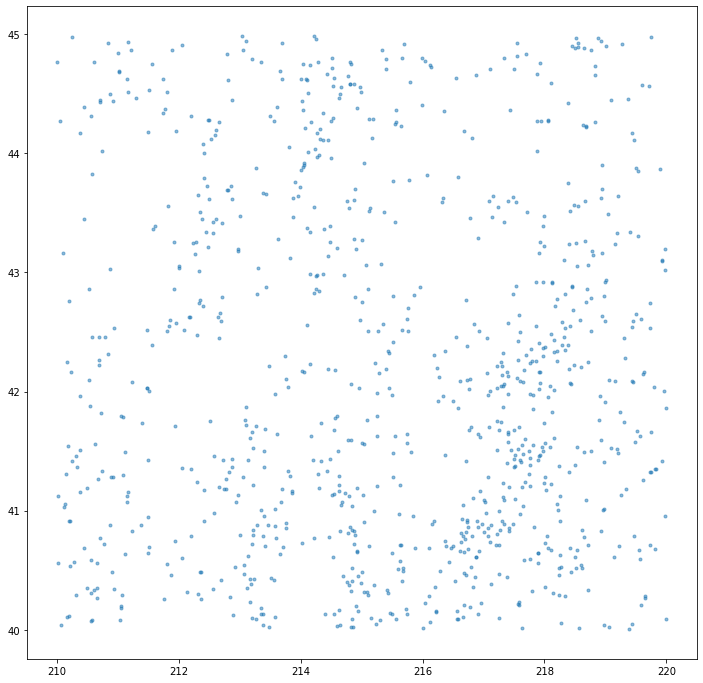

In [70]:
plt.figure(figsize = (12, 12))
plt.plot(timed_result_8[0].RA_central, timed_result_8[0].DEC_central, ".", alpha = 0.5)
plt.show()